In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import dlib

#### Definir função para apresentar múltiplas imagens, ou apenas uma

In [2]:
def show_multiple_images(pixels_array, rows, imgs_per_row, title):
    f, ax = plt.subplots(rows, imgs_per_row, figsize=(12,4))
    
    for idx, img in enumerate(pixels_array):
        ax[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    f.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def show_image(pixels, title=''):
    f, ax = plt.subplots(1, 1, figsize=(12,4))
    plt.imshow(cv2.cvtColor(pixels, cv2.COLOR_BGR2RGB))
    f.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

#### Identificar faces e carregar um método pré-treinado que vai pegar os principais pontos faciais do indivíduo, no caso, 68 pontos

In [3]:
frontal_face_detector = dlib.get_frontal_face_detector()
frontal_face_predictor = dlib.shape_predictor('./utils/shape_predictor_68_face_landmarks.dat')

#### Ler as imagens originais e convertê-las para preto-e-branco

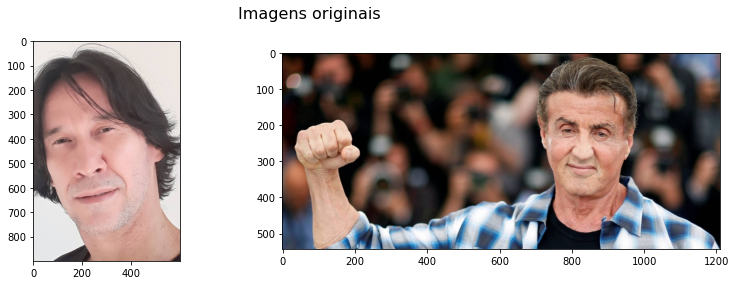

In [4]:
img_1, img_2 = cv2.imread('./input/jeeves.jpg'), cv2.imread('./input/rambo.jpg')
img_1_copy, img_2_copy = img_1, img_2
img_1_original, img_2_original = img_1.copy(), img_2.copy()
img_1_grayscale, img_2_grayscale = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY), cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)
show_multiple_images([img_1_copy, img_2_copy], 1, 2, 'Imagens originais')

#### Criando uma matriz do tamanho da primeira imagem em preto-e-branco

#### Pegar o tamanho e canais da segunda imagem

#### Criar uma matriz com as dimensões e canais da segunda imagem 

In [5]:
img_1_canvas = np.zeros_like(img_1_grayscale)
height, width, number_of_channels = img_2.shape
img_2_canvas = np.zeros((height, width, number_of_channels), np.uint8)

#### Achar as faces nas imagens, o que que retornará um array contendo as diagonais da face ( canto superior esquerdo e inferior direito )

In [6]:
faces_1, faces_2 = frontal_face_detector(img_1_grayscale), frontal_face_detector(img_2_grayscale)

#### Atravessar as faces da primeira imagem e detectar os pontos principais delas
#### Pega os 68 pontos principais da face e adiciona-os a lista de pontos faciais
#### Destaca os pontos faciais principais e apresenta a imagem

In [7]:
def set_landmarks(face_landmarks, face_landmark_points, img):
    for landmark in range(68):
        x = face_landmarks.part(landmark).x
        y = face_landmarks.part(landmark).y

        face_landmark_points.append((x, y))
        cv2.putText(img, str(landmark), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.25, (255, 255, 255), 1)
        cv2.circle(img, (x, y), 2, (0, 0, 255), -1)

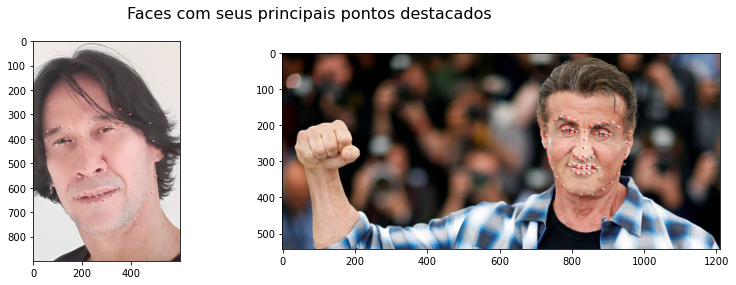

In [8]:
face_1_landmarks, face_2_landmarks = frontal_face_predictor(img_1_grayscale, faces_1[0]),\
                                        frontal_face_predictor(img_2_grayscale, faces_2[0])
face_1_landmark_points, face_2_landmark_points = [], []
img_1_with_landmarks_and_numbers, img_2_with_landmarks_and_numbers = img_1_original.copy(), img_2_original.copy()

set_landmarks(face_1_landmarks, face_1_landmark_points, img_1_with_landmarks_and_numbers)
set_landmarks(face_2_landmarks, face_2_landmark_points, img_2_with_landmarks_and_numbers)

show_multiple_images([img_1_with_landmarks_and_numbers, img_2_with_landmarks_and_numbers], 1, 2, 'Faces com seus principais pontos destacados')

#### Achar a envoltória convexa dos pontos principais da imagem, ou seja, o menor conjunto convexo que contém os pontos destacados anteriormente. Aplicando a face na máscara posteriormente

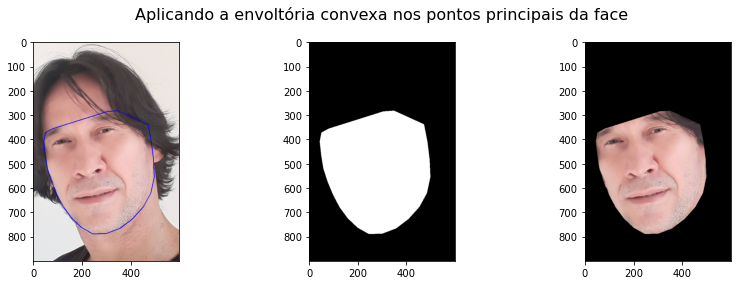

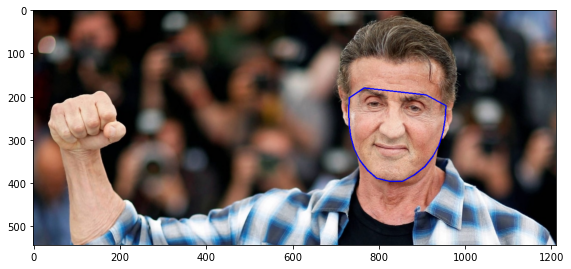

In [9]:
face_1_landmark_points_array, face_2_landmark_points_array = np.array(face_1_landmark_points, np.int32),\
                                                                np.array(face_2_landmark_points, np.int32)
face_1_convex_hull, face_2_convex_hull = cv2.convexHull(face_1_landmark_points_array),\
                                            cv2.convexHull(face_2_landmark_points_array)

cv2.polylines(img_1, [face_1_convex_hull], True, (255, 0, 0), 2)
cv2.polylines(img_2, [face_2_convex_hull], True, (255, 0, 0), 2)

cv2.fillConvexPoly(img_1_canvas, face_1_convex_hull, 255), cv2.fillConvexPoly(img_2_canvas, face_2_convex_hull, 255)
face_1_trimmed = cv2.bitwise_and(img_1_original, img_1_original, mask=img_1_canvas)
show_multiple_images([img_1, img_1_canvas, face_1_trimmed], 1, 3, 'Aplicando a envoltória convexa nos pontos principais da face')
show_image(img_2)

#### Utilizar a Triangulação de Delaunay para a criação de uma malha contígua de pontos triangulares que não se entrelaçam

#### Um retângulo será encontrado ao redor dos pontos da envoltória convexa da imagem, criação de uma subdivisão de Delaunay, incluindo todos os pontos do retângulo e retornar a lista de triangulos posteriormente, com 6 itens por vetor de triangulo (x, y) dos 3 pontos

#### Ao invés de trabalhar com os triângulos, pegaremos os índices do principais pontos faciais do i      indivíduo, sendo assim, agora teremos o índice dos pontos principais armazenados facilitando o         processo de swap com a outra imagem. Basicamente transformando os triângulos de um sistema de         coordenadas (x, y) para o formato de pontos faciais principais

In [10]:
bounding_rectangle = cv2.boundingRect(face_1_convex_hull)
subdivision = cv2.Subdiv2D(bounding_rectangle)
subdivision.insert(face_1_landmark_points)
triangles_vector = subdivision.getTriangleList()
triangles_array = np.array(triangles_vector, dtype=np.int32)
triangles_vertices = [] 

In [11]:
def fetch_index_from_numpy_array(np_array):
    for n in np_array[0]: return n
    
def get_vertex_as_landmarrk_point(landmark_points_array, vertex):
    vertex = np.where((face_1_landmark_points_array == vertex).all(axis=1))
    vertex = fetch_index_from_numpy_array(vertex)
    return vertex

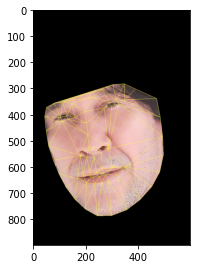

In [12]:
for triangle in triangles_array:
    vertex_1 = (triangle[0], triangle[1])
    vertex_2 = (triangle[2], triangle[3])
    vertex_3 = (triangle[4], triangle[5])
    line_color = (51,255,255)
    cv2.line(face_1_trimmed, vertex_1, vertex_2, line_color, 1)
    cv2.line(face_1_trimmed, vertex_2, vertex_3, line_color, 1) 
    cv2.line(face_1_trimmed, vertex_3, vertex_1, line_color,1)
    
    vertex_1 = get_vertex_as_landmarrk_point(face_1_landmark_points_array, vertex_1)
    vertex_2 = get_vertex_as_landmarrk_point(face_1_landmark_points_array, vertex_2)
    vertex_3 = get_vertex_as_landmarrk_point(face_1_landmark_points_array, vertex_3)
    
    triangle = [vertex_1, vertex_2, vertex_3]
    triangles_vertices.append(triangle)
    
show_image(face_1_trimmed)

#### Cortar os triangulos demarcados de ambas as fotos
- Capturar as coordenadas dos triângulos
- Destacar um retângulo ao redor desse triângulo
- Cortar o retângulo para depois colá-lo na segunda imagem
- Remover os pontos do retângulo 
- Para determinar os triângulos para a segunda foto os mesmos índices dos pontos faciais principais são utilizados (da lista de triâgulos da primeira foto, contendo os índices dos pontos faciais princiais), e também haverá um retângulo ao redor do triângulo da segunda imagem. Para cada triângulo demarcado na segunda imagem uma nova máscara é criada com os pontos do triangulo relativos a segunda imagem
- Ajustar a máscara da imagem 1 para caber na máscara recortada da imagem 2 utilizando transformação afim
- Reconstrução da segunda imagem utilizando os triângulos após a transformação a fim de manter as proporções da face original
- Por fim, recorta-se um setor da nova imagem 2 (será utilizado um canvas preto a ser preenchido), transforma-o para preto-e-branco e retira-se as secções brancas do triângulo para melhorar na interpolação destes. Utilizando esta máscara que filtra os pontos brancos, o triângulo recortado relativo a segunda imagem é adicionado ao canvas. Para cada triângulo extraído da imagem 1

In [13]:
def extract_triangle(face_landmark_points, triangle_index_points):
    point_1 = face_landmark_points[triangle_index_points[0]]
    point_2 = face_landmark_points[triangle_index_points[1]]
    point_3 = face_landmark_points[triangle_index_points[2]]
    triangle = np.array([point_1, point_2, point_3], np.int32)
    
    return point_1, point_2, point_3, triangle

def get_rectangle(triangle):
    rectangle = cv2.boundingRect(triangle)
    (x, y, w, h) = rectangle
    return rectangle, (x, y, w, h)

def draw_rectangle(point_1, point_2, point_3, rectangle_visualization, rectangle, crop, i, txt):
    (x, y, w, h) = rectangle
    cv2.line(rectangle_visualization, point_1, point_2, (200, 100, 0), 1)
    cv2.line(rectangle_visualization, point_2, point_3, (200, 100, 0), 1)
    cv2.line(rectangle_visualization, point_3, point_1, (200, 100, 0), 1)
    cv2.rectangle(rectangle_visualization, (x, y), (x + w, y + h), (0, 0, 255), 1)
    show_multiple_images([rectangle_visualization, crop], 1, 2, txt)
    
def extract_triangle_points(point_1, point_2, point_3, x, y):
    return np.array([[point_1[0] - x, point_1[1] - y],
                     [point_2[0] - x, point_2[1] - y],
                     [point_3[0] - x, point_3[1] - y]], np.int32)

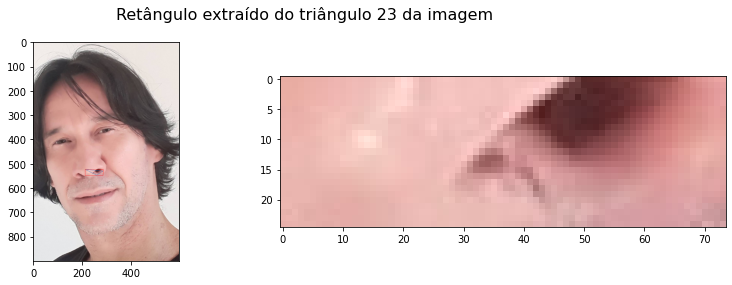

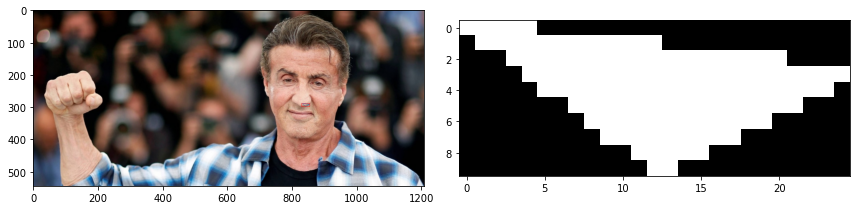

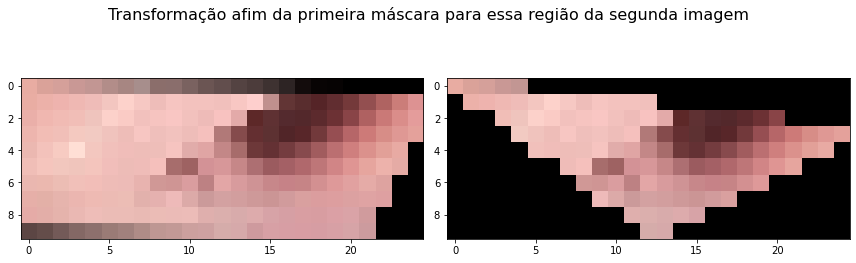

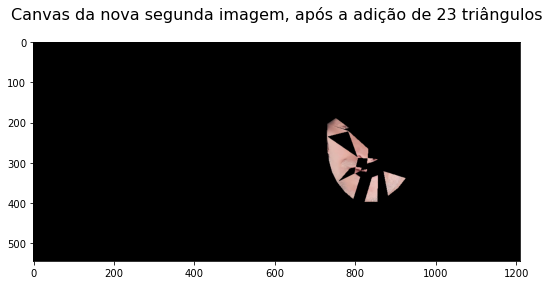

In [14]:
rectangle_visualization_1, rectangle_visualization_2  = img_1_original.copy(), img_2_original.copy()
img_2_canvas = np.zeros((height, width, number_of_channels), np.uint8)
for i, triangle_index_points in enumerate(triangles_vertices):
    triangle_1_point_1, triangle_1_point_2, triangle_1_point_3, triangle_1 = extract_triangle(face_1_landmark_points, triangle_index_points)
    rectangle_1, (x, y, w, h) = get_rectangle(triangle_1)
    
    cropped_rectangle_1 = img_1_original[y: y + h, x: x + w]
    
    triangle_1_points = extract_triangle_points(triangle_1_point_1, triangle_1_point_2, triangle_1_point_3, x, y)
        
    triangle_2_point_1, triangle_2_point_2, triangle_2_point_3, triangle_2 = extract_triangle(face_2_landmark_points, triangle_index_points)  
    rectangle_2, (x, y, w, h) = get_rectangle(triangle_2)
    
    cropped_rectangle_2_mask = np.zeros((h, w), np.uint8)
    
    triangle_2_points = extract_triangle_points(triangle_2_point_1, triangle_2_point_2, triangle_2_point_3, x, y)    
    cv2.fillConvexPoly(cropped_rectangle_2_mask, triangle_2_points, 255)
    
    triangle_1_points, triangle_2_points = np.float32(triangle_1_points), np.float32(triangle_2_points)
    transformation_matrix = cv2.getAffineTransform(triangle_1_points, triangle_2_points)
    warped_rectangle = cv2.warpAffine(cropped_rectangle_1, transformation_matrix, (w, h))
    warped_triangle = cv2.bitwise_and(warped_rectangle, warped_rectangle, mask=cropped_rectangle_2_mask) 
    
    face_2_canvas_area = img_2_canvas[y: y + h, x: x + w]
    face_2_canvas_area_grayscale = cv2.cvtColor(face_2_canvas_area, cv2.COLOR_BGR2GRAY)
    _, mask_created_triangle = cv2.threshold(face_2_canvas_area_grayscale, 1, 255, cv2.THRESH_BINARY_INV)

    wraped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_created_triangle)

    face_2_canvas_area = cv2.add(face_2_canvas_area, wraped_triangle)
    img_2_canvas[y: y + h, x: x + w] = face_2_canvas_area
    if i == 23:
        draw_rectangle(triangle_1_point_1, triangle_1_point_2, triangle_1_point_3,\
                        rectangle_visualization_1, rectangle_1, cropped_rectangle_1, i, 'Retângulo extraído do triângulo {0} da imagem'.format(i))
        draw_rectangle(triangle_2_point_1, triangle_2_point_2, triangle_2_point_3,\
                        rectangle_visualization_2, rectangle_2, cropped_rectangle_2_mask, i, '')
        show_multiple_images([warped_rectangle, warped_triangle], 1, 2, 'Transformação afim da primeira máscara para essa região da segunda imagem')
        show_image(img_2_canvas, 'Canvas da nova segunda imagem, após a adição de {0} triângulos'.format(i))

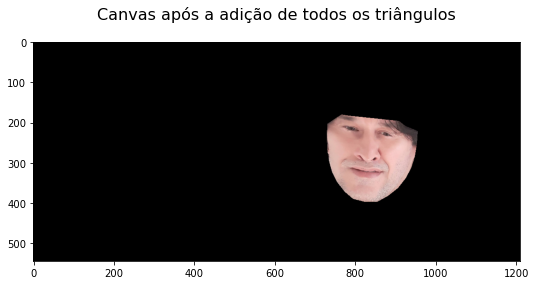

In [15]:
show_image(img_2_canvas, 'Canvas após a adição de todos os triângulos')

### Criação de um novo canvas para guardar a face após o swap, esse canvas terá o tamanho da segunda imagem. Depois há o preenchimento da envoltória convexa com esses pontos ( envolvendo a face da segunda image ), após isso a máscara é adicionada a imagem original e por fim, ela é preenchida pela face pós-swap

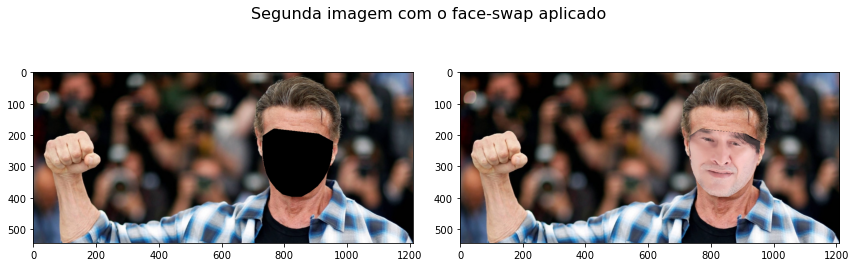

In [16]:
img_2_face_mask_canvas = np.zeros_like(img_2_grayscale)
img_2_face_mask = cv2.fillConvexPoly(img_2_face_mask_canvas, face_2_convex_hull, 255)
img_2_face_mask_canvas = cv2.bitwise_not(img_2_face_mask)
img_2_without_face = cv2.bitwise_and(img_2_original, img_2_original, mask=img_2_face_mask_canvas)
img_2_with_face = cv2.add(img_2_without_face, img_2_canvas)
show_multiple_images([img_2_without_face, img_2_with_face], 1, 2, 'Segunda imagem com o face-swap aplicado')

#### Utilizar o método Seamless Clone deixando a nova face mais natural e ajustada a imagem original, para tanto, faz-se necessário encontrar o ponto central da envoltória convexa da imagem, tornando-o mais natural a partir deste ponto,  outrossim, utilizará a imagem original, visando capturar a iluminação e cores dela

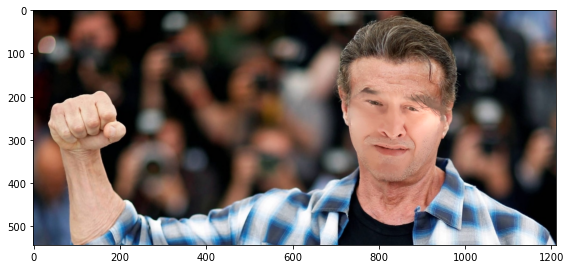

In [17]:
(x, y, w, h) = cv2.boundingRect(face_2_convex_hull)
face_2_center_point = (int((x+x+w)/2), int((y+y+h)/2))
seamless_cloned = cv2.seamlessClone(img_2_with_face, img_2_original, img_2_face_mask, face_2_center_point, cv2.NORMAL_CLONE)
show_image(seamless_cloned)